# Classification des CV avec NLP

### Contexte du projet

Embaucher les bons talents est un défi pour toutes les entreprises. Ce défi est amplifié par le volume élevé de candidats si l'entreprise est bien réputée. Dans une organisation de services typique, des professionnels possédant une variété de compétences techniques et d'expertise sont embauchés et affectés à des projets pour résoudre les problèmes des clients.

En règle générale, les grandes entreprises n'ont pas assez de temps pour ouvrir chaque CV. L’idée du projet est d’utiliser des algorithmes d'apprentissage automatique pour la tâche de filtrage de CV.


Nous sommes ici dans le cadre d'une classification multi classes puisque l'objectif de notre étude est de classer 
notre CV dans une catégorie précise.

Nous allons dans un premier temps expliquer ce qu’est la classification multilabels. 
Elle consiste simplement à dire qu’au lieu d’attribuer une seule classe à une instance donnée, 
cette instance peut appartenir à plusieurs classes. 

# 1. Lecture et visualisation des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [2]:
dataset = pd.read_csv("DataSet.csv", sep=',')
#dataset['cleaned_resume'] = ''

In [3]:
dataset

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [5]:
dataset.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [6]:
dataset.isnull().sum()

Category    0
Resume      0
dtype: int64

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

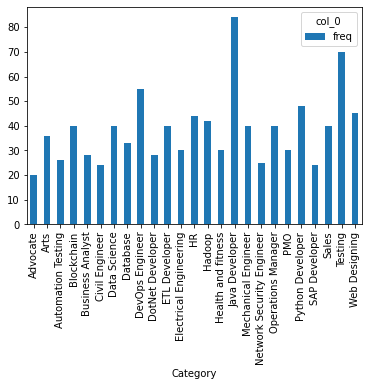

In [8]:
t = pd.crosstab(dataset.Category, "freq")
t.plot.bar()

On observe que les classes les plus fréquentes sont les classes "Java Developper" et "Testing".

Les algorithmes conventionnels sont souvent biaisés en faveur de la classe majoritaire, ne tenant pas compte de 
la distribution des données. Dans le pire des cas, les classes minoritaires sont traitées comme des valeurs 
aberrantes et ignorées. Dans certains cas, nous aurions besoin de configurer soigneusement notre modèle ou 
d'équilibrer artificiellement l'ensemble de données, par exemple en sous-échantillonnant ou en suréchantillonnant
chaque classe.

Cependant, dans notre cas d'apprentissage de données déséquilibrées, les classes majoritaires pourraient être de 
notre grand intérêt. Il est souhaitable d'avoir un classificateur qui donne une précision de prédiction élevée 
sur la classe majoritaire, tout en maintenant une précision raisonnable pour les classes minoritaires. 
Par conséquent, nous le laisserons tel quel.

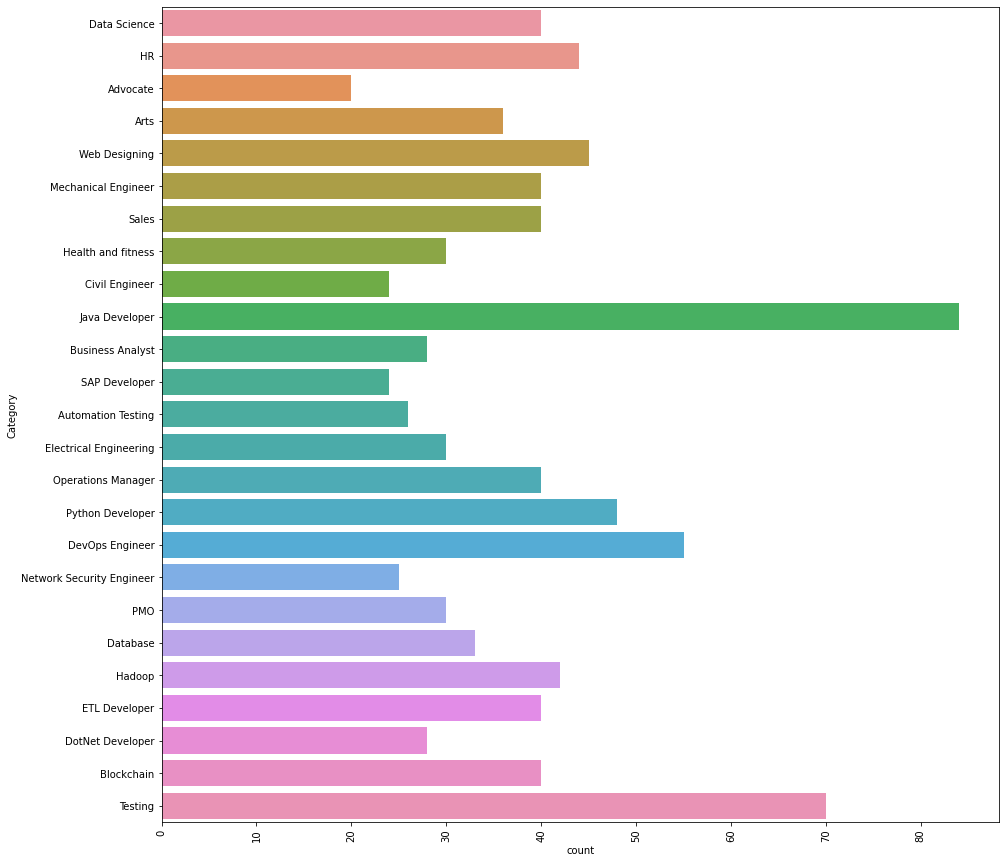

In [9]:
#sns.countplot(dataset['Category'])

plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=dataset)


In [10]:
variables = (dataset.dtypes == 'object')
object_cols = list(variables[variables].index)

#Nombre des labels des variables catégorielles
for var in object_cols:
    print(f"{var} contains {len(dataset[var].unique())} labels")
    
#On détermine le nombre d'occurrences de nos variables qualitatives

for var in object_cols:
    print(var)
    print("***********************************************")
    print(dataset[var].value_counts())
    print("==============================================")


Category contains 25 labels
Resume contains 166 labels
Category
***********************************************
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
Data Science                 40
Operations Manager           40
Sales                        40
ETL Developer                40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
PMO                          30
Health and fitness           30
DotNet Developer             28
Business Analyst             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: Category, dtype: int64
Resume
***********************************************
Tech

Nous avons 25 labels pour la variable catégorielle "Category".

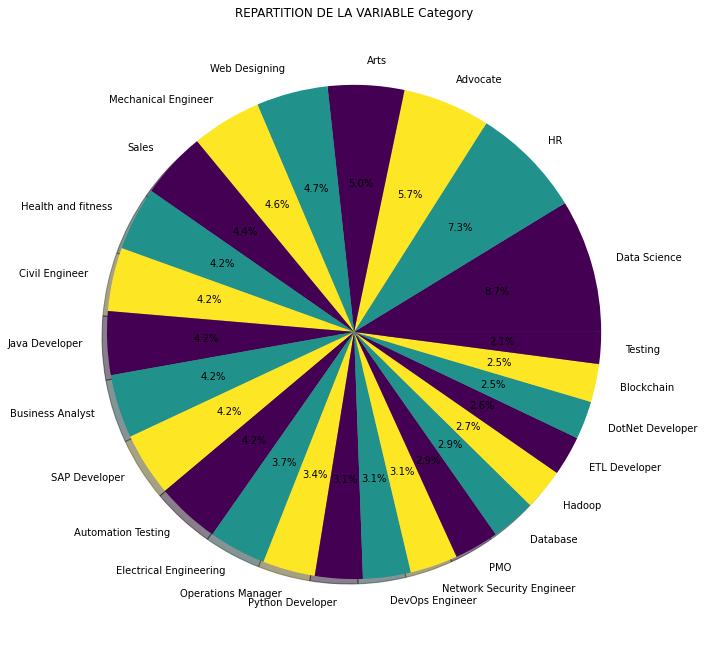

In [11]:
from matplotlib.gridspec import GridSpec
targetCounts = dataset['Category'].value_counts()
targetLabels  = dataset['Category'].unique()

plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='REPARTITION DE LA VARIABLE Category')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

## Caractéristiques des commentaires

On va Crée un code qui permet d’afficher les mots prédominants dans les commentaires (variable resume). 
On va optez par la méthodeWordCloud() du module wordcloud.

Voici le nuage de mots des mots fréquemment utilisés dans les commentaires. Un maximum de 50 mots est affiché.


(-0.5, 399.5, 199.5, -0.5)

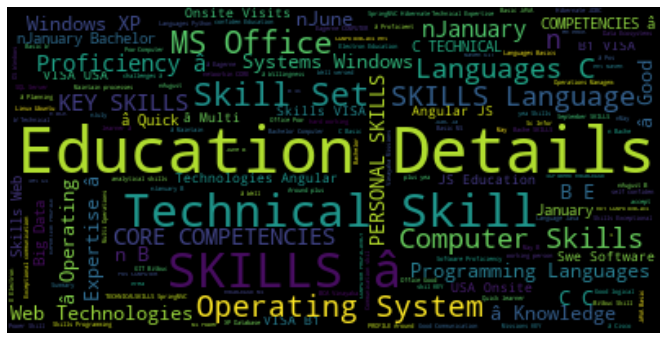

In [12]:
from wordcloud import WordCloud

text = dataset['Resume'].to_string()

wcloud = WordCloud(max_font_size=60).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")

# 2. Nettoyage des données et prétraitement de texte

L’objectif est tout d'abord de nettoyer le texte afin de faciliter l’apprentissage. Pour entraîner Word2Vec, il 
est préférable de ne pas supprimer les mots vides car l’algorithme s’appuie sur le contexte plus large de la 
phrase afin de produire des vecteurs de mots de haute qualité. On va créer une fonction qui prend en paramètres 
un review et qui renvoie le review nettoyé (liste des mots). Pour ce faire:

Tout d’abord on va supprimer les balises HTML. Pour cela, vous utiliserez la bibliothèque Beautiful Soup. 




In [13]:
# Importation des bibliothèques necessaires au nettoyage
from bs4 import BeautifulSoup
import re
import nltk


### Nettoyage des données: 

* suppression des balises
* des caractères qui ne sont pas des lettres. 
* On découpe les phrases en mots et on supprime les mots vides 

In [14]:
def review_wordlist(data, stopwords = False):
    
    # Suppression de la balise HTML
    review = BeautifulSoup(data,'html.parser').get_text()
    
    # suppression des caractères qui ne sont pas des lettres
    review = re.sub('[^a-zA-Z]', ' ', review)
    
    # Convertion en minuscule
    review = review.lower()
    
    # Découpage des phrases en mots
    word = nltk.word_tokenize(review)
    
    # suppression des mots vides (faux par défaut)
    if stopwords:
        stops = set(nltk.corpus.stopwords.words("english"))
        
        words = [w for w in word if not w in stops]
    
    return word

Maintenant on a besoin un format d’entrée spécifique pour notre algorithme. 
Word2Vec attend des phrases uniques, chacune représente une liste de mots. En d’autres termes, le format d’entrée
est une liste de listes. Les phrases en anglais peuvent se terminer par "?", "!", Ou". ", et l’espacement et 
la capitalisation ne sont pas non plus des guides fiables. On va donc utiliser le le tokenizer punkt de NLTK 
pour le fractionnement de phrases. 

     

### **Fractionnement d'un paragraphe en phrases**

In [15]:
# word2vec attend une liste de listes.
# Utilisation du tokenizer punkt pour une meilleure division d'un paragraphe en phrases.


import nltk.data
#nltk.download('popular')
# nltk.download()

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
#tokenizer.tokenize(votretext)


Ensuite, on va définir une fonction qui prend en paramètre le paragraphe du review et le tokenizer et qui renvoie
la liste des phrases, tel que chaque phrase est une liste des mots. 

In [16]:
# Cette fonction divise le review en phrases
def review_sentences(review, tokenizer, remove_stopwords=False):
    
    # 1. Utilisation du nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Boucle sur chaque phrase
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence,remove_stopwords))

    # retourne une liste de listes
    return sentences

La chose la plus importante est de diviser les phrases par phrases avant de les diviser en un seul mot, car vous 
perdrez les informations sur les mots qui ont formé une phrase si vous la divisez d'abord en mots. 
On pourrait penser que faire une division pourrait suffire à diviser un paragraphe en phrases; cependant, 
les phrases anglaises peuvent se terminer par de nombreuses ponctuations et il n'est pas étrange que quoi que ce 
soit puisse être placé à la fin des phrases. Pour cette raison, lorsque nous divisons le texte en phrases, nous 
devons utiliser le tokenizer punkt de NLTK (la fonction sent_tokenize utilise une instance d'un tokenizer punkt).
Le tokenizer punkt est un modèle entraînable non supervisé, qui permet au tokenizer d'utiliser pour décider où 
couper ou apprendre les abréviations dans le texte.

In [17]:
sentences = []

# Ajout des reviews.
for review in dataset["Resume"]:
    sentences += review_sentences(review, tokenizer)


C:\Users\utilisateur\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [18]:
print(len(sentences))
print()
print(sentences[:2])


21599

[['skills', 'programming', 'languages', 'python', 'pandas', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib', 'sql', 'java', 'javascript', 'jquery'], ['machine', 'learning', 'regression', 'svm', 'na', 've', 'bayes', 'knn', 'random', 'forest', 'decision', 'trees', 'boosting', 'techniques', 'cluster', 'analysis', 'word', 'embedding', 'sentiment', 'analysis', 'natural', 'language', 'processing', 'dimensionality', 'reduction', 'topic', 'modelling', 'lda', 'nmf', 'pca', 'neural', 'nets']]


On obtient ici les deux premières listes de mots.

Nos données dont désormais bien nettoyées. Nous avons effectué une "Tokenisation", ou découpage du texte en 
plusieurs pièces appelés "tokens". On a également procéde à d'autres opérations de nettoyage comme la 
suppression des chiffres, ponctuation, symboles et stopwords, passage en minuscule. 


# 3. Apprentissage et enregistrement de votre modèle

## Encodage de la variable Catégorielle "Category"

In [19]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    dataset[i] = le.fit_transform(dataset[i])
print ("Conversion de la variable catégorielle Category")

Conversion de la variable catégorielle Category


Avec la liste des phrases bien nettoyées, nous sommes prêts à entraîner le modèle. Il existe un certain nombre de choix de paramètres qui affectent la durée d’exécution et la qualité du modèle final produit.

* **Architecture**: Les options d’architecture sont skip-gram (par défaut) ou CBOW. Il a été constaté que skip-gramme était légèrement plus lent mais produisait de meilleurs résultats.

* **Algorithme d’entraînement**: Hierarchical softmax (default) ou negative sampling. Optez par la valeur par défault qui semble bien fonctionner.

* **Sous-échantillonnage des mots fréquents**: La documentation Google recommande des valeurs comprises entre .00001 et .001.

* **Word vector dimensionality**: plus de features se traduisent par des temps d’exécution lentes, mais pas toujours, de meilleurs modèles. Les valeurs raisonnables peuvent être comprises entre des dizaines et des centaines. Optez par la valeur 300.

* **Context / window size**: Combien de mots de contexte l’algorithme d’apprentissage doit-il prendre en compte?

* **Worker threads**: Nombre de processus parallèles à exécuter. Ceci est spécifique à l’ordinateur, mais entre 4 et 6 devraient fonctionner sur la plupart des systèmes.

* **Minimum word count**: Cela permet de limiter la taille du vocabulaire à des mots significatifs. Tout mot qui n’apparaît pas au moins autant de fois dans tous les documents est ignoré. Les valeurs adaptées peuvent être comprises entre 10 et 100. 


### Initialisation et entraînement du modèle en utilisant l’objet "word2vec" du sous-module "models" du module "gensim"

En général, il existe deux types d'options d'architecture: skip-gram (par défaut) et CBOW (sac continu de mots).
La plupart du temps, le skip-gramme est un peu plus lent mais a plus de précision que CBOW. CBOW est la méthode
pour prédire un mot par un texte entier; par conséquent, un petit ensemble de données est plus favorable. 
D'autre part, skip-gram est totalement opposé à CBOW. Avec le mot cible, skip-gram est la méthode pour prédire 
les mots autour des mots cibles. Plus nous avons de données, meilleures sont les performances. 
En tant qu'architecture, il existe deux algorithmes d'apprentissage pour Word2Vec: Softmax hiérarchique 
(par défaut) et échantillonnage négatif. Nous utiliserons la valeur par défaut.

In [20]:
from gensim.models import word2vec

Création du modèle et réglage des valeurs des différents paramètres

In [21]:

#paramètres du modèle

#architecture par défaut: skip-gram
#algorithme par défaut: Hierarchical softmax

num_features = 300    #Dimensionnalité de vecteur de mot
min_count = 30        #Nombre minimum de mots
num_processor = 4     #Nombre de fils parallèles (Nombre de processus parallèles à exécuter: en général valeur comprise entre 4 et 6)
context = 10          #Taille de la fenêtre contextuelle
downsampling = 0.001  #Réglage de sous-échantillonnage pour les mots fréquents (compris entre 0.00001 et 0.001)


Initialisation et entraînement du modèle

In [22]:
# Initialisation du modèle d'entraînement


model = word2vec.Word2Vec(sentences, workers = num_processor, 
                         size = num_features, min_count = min_count,
                         window = context, sample = downsampling)



In [23]:
#model[model.wv.vocab]

**Nombre minimum de mots**: cela permet de limiter la taille du vocabulaire aux mots significatifs. 
Tout mot qui n'apparaît pas au moins autant de fois dans tous les documents est ignoré. 
Les valeurs raisonnables pourraient être comprises entre 10 et 100. 

In [24]:
# Déchargez la mémoire inutile une fois le processus d'apprentissage terminé.
# Pour rendre la mémoire du modèle efficace
model.init_sims(replace = True)

Enregistrez ce modèle dans un fichier après l’avoir entraîner

In [25]:
# Enregistrement du modèle.
model_name = "CVclassifier"
model.save(model_name)

# Sac des centroïdes: Création de clusters

Word2Vec crée des clusters de mots sémantiquement liés, une autre approche possible consiste donc à exploiter la 
similitude des mots au sein d’un cluster. Le regroupement de vecteurs de cette manière est connu sous le nom de
«quantification vectorielle». Pour ce faire, on doit d’abord trouver les centres des clusters de mots, ce que 
l'on peut faire en utilisant un algorithme de clustering tel que K-Means. Dans K-Means, le seul paramètre que 
l'on doit définir est "K" qui représente le nombre de clusters. Comment décider du nombre de clusters à créer? 
Les essais et erreurs ont suggéré que les petits groupes, avec une moyenne de seulement 5 mots environ par 
groupe, donnaient de meilleurs résultats.

### 1. Récupérer le nombre de clusters obtenu à partir du vocabulaire de votre modèle Word2Vec.

In [26]:
from sklearn.cluster import KMeans
import time

In [27]:
print(model.wv.vectors.shape)

(1859, 300)


In [28]:
print(model.wv.syn0.shape)

(1859, 300)


<ipython-input-28-3b143c508b1e>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  print(model.wv.syn0.shape)


In [29]:
num_clusters = model.wv.syn0.shape[0] // 5
num_clusters

<ipython-input-29-0eab2f649804>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  num_clusters = model.wv.syn0.shape[0] // 5


371

On obtient 371 clusters à partir de notre voccabulaire du modèle Word2Vec.

On va initialiser la méthode Kmeans de "sklearn.cluster" et utiliser les données du modèle Word2vec pour 
extraire les centroids. On utilise le nombre de clusters obtenu dans l’étape précédente comme paramètre de 
la méthode et fit_predict pour l’utilisation.

In [30]:
start = time.time()

kmean = KMeans(n_clusters = num_clusters)
index = kmean.fit_predict(model.wv.syn0)

end = time.time()
print("Temps nécessaire pour le clustering K-Means: ", end - start, "secondes.")

<ipython-input-30-da97ec525b16>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  index = kmean.fit_predict(model.wv.syn0)


Temps nécessaire pour le clustering K-Means:  24.66054391860962 secondes.


Chaque ligne de word2vec représente chaque mot apparu dans les données après le processus de nettoyage. 
La colonne représente chaque variable de valeur vectorielle. 

L’affectation de cluster pour chaque mot est maintenant stockée dans la valeur de retour de l’étape précédent, et
le vocabulaire du modèle Word2Vec d’origine est toujours stocké dans "model.wv.index2word". 
On enregistre les résultats dans un dictionnaire où les clés sont les mots et les valeurs sont les centroides.

In [31]:
word_centroid_map = dict(zip( model.wv.index2word, index ))
word_centroid_map.values()

dict_values([138, 1, 141, 308, 288, 260, 65, 370, 181, 233, 65, 181, 65, 220, 195, 183, 360, 224, 273, 234, 194, 63, 167, 300, 89, 346, 369, 9, 61, 250, 89, 181, 362, 347, 89, 84, 193, 65, 91, 131, 48, 296, 171, 167, 63, 238, 282, 257, 96, 91, 172, 181, 225, 98, 196, 52, 349, 98, 111, 193, 59, 317, 40, 365, 74, 63, 135, 65, 191, 32, 269, 48, 251, 167, 63, 351, 365, 282, 325, 310, 269, 349, 140, 87, 276, 356, 321, 195, 201, 327, 350, 135, 203, 200, 239, 194, 37, 98, 24, 287, 304, 258, 108, 145, 153, 212, 71, 242, 124, 281, 32, 307, 81, 219, 202, 117, 193, 168, 59, 111, 243, 101, 58, 225, 199, 247, 284, 37, 63, 78, 52, 165, 162, 318, 284, 62, 275, 162, 162, 75, 197, 68, 367, 108, 202, 142, 101, 293, 361, 265, 78, 108, 203, 129, 108, 96, 105, 4, 162, 106, 46, 68, 165, 63, 139, 318, 276, 143, 355, 52, 14, 133, 249, 355, 20, 196, 256, 178, 349, 1, 286, 242, 205, 105, 166, 312, 306, 124, 31, 170, 24, 330, 48, 72, 31, 123, 312, 196, 182, 196, 63, 295, 80, 177, 96, 52, 295, 180, 79, 91, 307, 2

On va regarder maintenant ce que contiennent nos clusters.

In [32]:
# Pour les 15 premiers clusters
for cluster in range(0,15):
    #
    # impression du numéro de cluster  
    print ("\nCluster %d" % cluster)
    #
    # liste des mots pour chaque numéro de cluster
    words = []
    values=list(word_centroid_map.values())
    keys=list(word_centroid_map.keys())
    for i in range(0,len(word_centroid_map.values())):
        if( values[i] == cluster ):
            words.append(keys[i])
    print (words)


Cluster 0
['model', 'map', 'extract', 'hbase', 'tableau', 'intelligence', 'nlp', 'wide', 'oozie', 'extraction']

Cluster 1
['the', 'through', 'entire', 'ui', 'target', 'given', 'achieved', 'responsive']

Cluster 2
['four', 'sense']

Cluster 3
['secondary', 'hsc', 'h', 'higher', 'phule', 'jr', 'amravati', 'savitribai', 'engg', 'junior', 'secured', 'october', 'class']

Cluster 4
['linux', 'unix', 'studio', 'visual', 'platforms', 'ftp', 'ubuntu']

Cluster 5
['communicating', 'partners', 'visit', 'channel', 'closing', 'negotiation']

Cluster 6
['specifications', 'specification', 'drawings', 'designs', 'low']

Cluster 7
['salary', 'barclays', 'ocean', 'gisss', 'jalloshband', 'multimedia', 'money']

Cluster 8
['troubleshooting', 'capacity', 'drives', 'mcc']

Cluster 9
['all', 'past', 'consignments', 'imports', 'moving']

Cluster 10
['operational', 'statutory']

Cluster 11
['problem', 'excellent', 'decision', 'analytical', 'thinking']

Cluster 12
['troubleshoot', 'configure']

Cluster 13
['a

On remarque que nos clusters sont déséquilibrés. Certains contiennent beaucoup de mots au détriment d'autres 
clusters qui ne contiennent qu'un seul mot.

### Création des sacs de centroïdes

In [33]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # Le nombre de clusters est égal à l'index de cluster le plus élevé
    # dans la carte mot/centroid
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pré-allouer le vecteur sac de centroïdes (pour la vitesse)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # On fait une boucle sur les mots de la critique. Si le mot est dans le vocabulaire,
    # on trouve à quel cluster il appartient et incrémenter ce nombre de clusters
    # par un

    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Retourne le "bag of centroids"
    return bag_of_centroids

### Fractionnement des données du dataset

In [35]:
#Partition du dataset en jeu d'apprentissage et de test


x_train, x_test, y_train, y_test= train_test_split(dataset["Resume"], dataset["Category"],test_size=0.2,random_state=42)

#x correspond à la variable "Resume"
#y correspond à la variable "Category"

On a maintenant pour chaque mot un cluster qui lui correspond (ou "centroïde"), et on peut définir une fonction 
pour convertir les reviews en sacs de centroïdes. 
On va créer une fonction qui prend en paramètre un review (liste des mots) avec le dictionnaire des clusters et 
qui renvoie le vecteur de sacs de centroïdes.

In [36]:
# Prétraitez les données pour l'entrée comme avant

#train_review = []

#for review in train['Resume']:
#    train_review.append(review_wordlist(review, stopwords= True))

#test_review = []

#for review in test['Resume']:
    #test_review.append(review_wordlist(review, stopwords = True))


In [39]:
# Pré-alloue un tableau pour les ensembles d'entraînement des sacs de centroïdes (pour la vitesse)

train_centroid = np.zeros((len(x_train), num_clusters), dtype = 'float32')
print(train_centroid.shape)


# Transformation des revues des ensembles d'entraînement en sacs de centroïdes
counter = 0
for review in x_train:
    train_centroid[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

(769, 371)


In [40]:

# Même opération pour le jeu de test
test_centroid = np.zeros((len(x_test), num_clusters), dtype = 'float32')
print(test_centroid.shape)

counter = 0
for review in x_test:
    test_centroid[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

(193, 371)


## Modélisation RandomForest

In [41]:
# Ajuster une forêt aléatoire et extraire des prédictions
forest = RandomForestClassifier(n_estimators = 100)


forest = forest.fit(train_centroid,y_train)
result = forest.predict(test_centroid)

# Write the test results 
#output = pd.DataFrame(data={"Category":result})
#output.to_csv( "BagOfCentroids.csv", index=False, quoting=3 )

### Matrice de Confusion

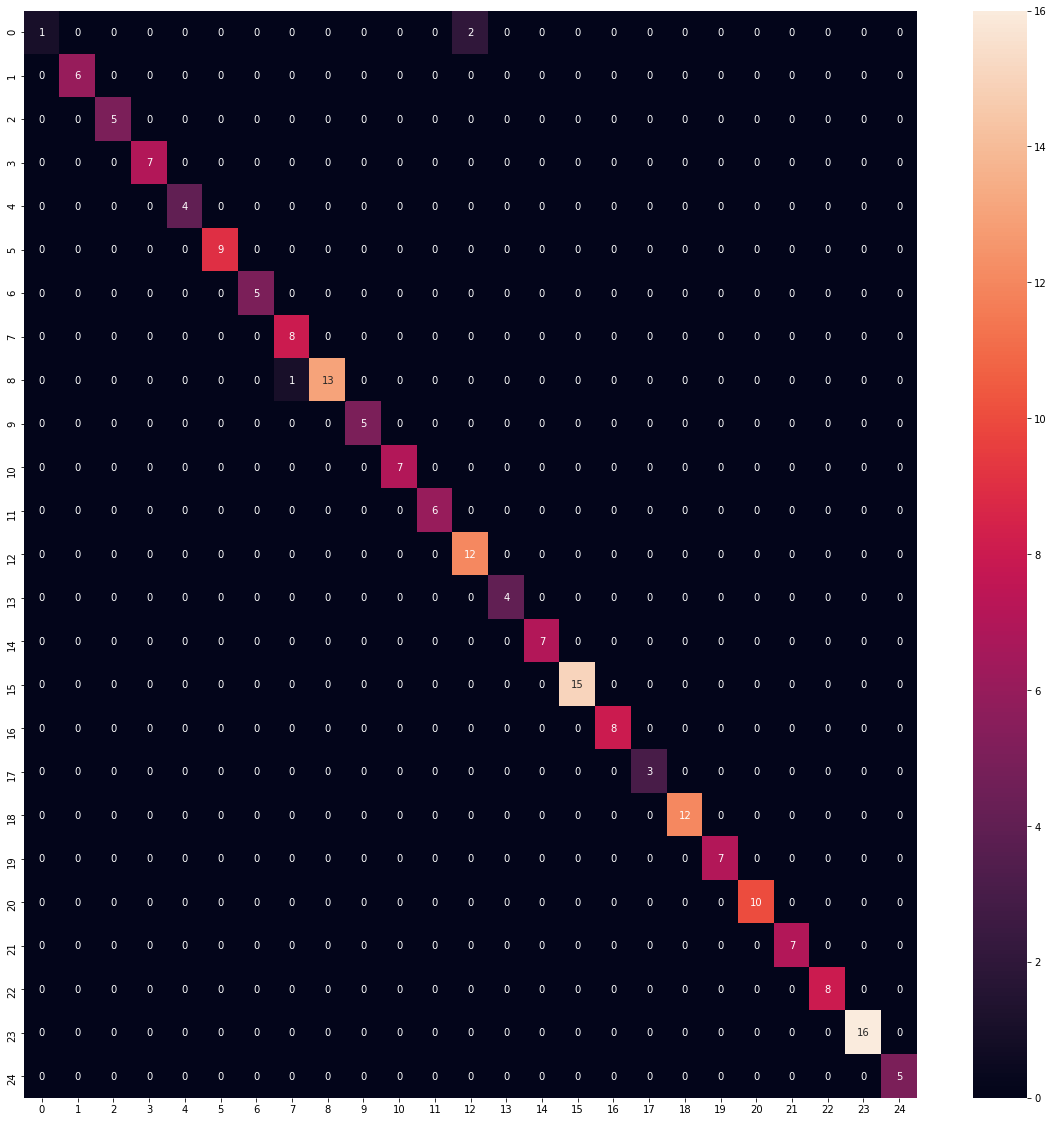

In [42]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, result)
plt.figure(figsize=(20,20))
sns.heatmap(conf, annot=True)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         5
           7       0.89      1.00      0.94         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       0.86      1.00      0.92        12
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00         8
          17       1.00    

On obtient de très bons résultats de notre modèle avec la méthode RandomForest puisque nous avons une accuracy de
98%.